# Packetized Energy Management

## Abstract

The energy grid regularly experiences undersupply conditions, or brownouts, where the available supply cannot fully meet the demand. To reduce this problem, flexible demand (defined as appliances with a latent energy reservoir) may be organized into chunks, called packets, which are requested by appliances. Packets are stochastically allowed for consumption according to  supply by the grid manager. This grid management method prevents grid overload by time-delaying energy use. Packetized grid management keeps the grid from being overloaded within normal operating conditions.

## Setup

In [1]:
import numpy as np
import random as rand
from matplotlib import rcParams
import matplotlib.pyplot as plt
from math import pi, cos, sin
import pandas as pd

In [2]:
total_epochs = 1175 # 1175 = approximately 1 week
population_size = 1000
grid_size = 900
period = 3600*24*7 # 7 days
epoch_length = 3600 # 60 minutes

# init empty lists to be added to later
der_types = []

## Define Dynamic Elements

#### Grid Supply Energy

$$
n = 4.16333941
\\~\\
a(T,t) = \pi(\frac{2t}{T}-1)
\\~\\
Σ P(s,a) = \frac{s}{n} [\cos(a)+2\sin^{2}(\sin(a))+\frac{1}{2}\sin(\frac{a}{7}-1)+2]
$$

In [3]:
def update_supply(time) -> float:
    
    n = 4.16333941
    a = pi * (2*time/period - 1)
    
    power = \
        (grid_size / n) \
        * (cos(a) + 2*(sin(sin(a)))**2 \
        + 0.5 * sin(a/7 - 1) \
        + 2)
    
    return power

#### Electric Water Heater (EWH) update through epoch:

$$
T(t) = T_{amb} + (T-T_{amb})e^{-kt}
\\~\\
T_{new} = T_{old} + 3z - \frac{T_{old}-T_{ambient}}{T_{target}} - T_{old} w
\\~\\
T_{new} = old + input - environmental \ loss - useage \ loss
$$

In [4]:
# define state
def init_ewh() -> dict:
    ewh = {
        'type' : 'ewh' ,
        'state' : rand.randint(45,60) ,
        'using' : False ,
        'requesting' : False ,
    }
    
    return ewh

# define control limits
ewh_lim = {
    # https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9305237&tag=1
    'target' : 60 ,
    'recover' : 35 ,
}


def update_temp(ewh: dict) -> int:

    eff = 0.7
    T_amb = 22
    T_out = 45
    vol = 55
    power = 1800
    
    # stochastic useage
    outflow = rand.random()
    if rand.randint(0,60) <= 2 : useage = rand.random()
    
    # update temperature
    ewh['state'] = \
        ewh['state'] \
        + (ewh['using'] * 2) \
        - (ewh['state'] - T_amb) / ewh_lim['target'] \
        - outflow
    
    return ewh['state']

# define state update procedure
def update_ewh(pop_df: pd.DataFrame) -> pd.DataFrame:

    # update EWHs state
    # this is the slowest operation here :(
    pop_df['state'] = pop_df.apply(lambda row: update_temp(row) if row.type == 'ewh' else row, axis=1)
    
    # disregard management and use energy if state too low
    pop_df['using'] = np.where(pop_df['state'] < ewh_lim['recover'], True, False)
    
    # update requests for state below lower limit
    pop_df['requesting'] = np.where(pop_df['state'] < ewh_lim['target'], True, False)
        
    return pop_df

# add EWH to der types
der_types.append(init_ewh)

## Modeling

### Initialization of DER population

In [5]:
columns = ['type','state','using','requesting']

def init_der() -> dict:
    init = rand.choice(der_types)
    return init()

data = [init_der() for _ in range(population_size)]

# init dataframe
pop_df = pd.DataFrame(data, columns=columns)

pop_df.reset_index(inplace=True)

pop_df.head(10)

,index,type,state,using,requesting
0,0,ewh,46,False,False
1,1,ewh,47,False,False
2,2,ewh,55,False,False
3,3,ewh,59,False,False
4,4,ewh,60,False,False
5,5,ewh,59,False,False
6,6,ewh,53,False,False
7,7,ewh,56,False,False
8,8,ewh,47,False,False
9,9,ewh,59,False,False


### Running the Simulation

In [6]:
def indicate_progress(i, total): print(f'{int(i/total*100)}%', end='\r')

In [7]:
load = []
state = []
iterations = total_epochs*epoch_length

for i in range(0, iterations, epoch_length) :
    
    indicate_progress(i, iterations)
    
    # update for EWHs
    pop_df = update_ewh(pop_df)
    
    # determine total useage & requests quantity
    num_requests = len(pop_df.loc[pop_df['requesting'] == True])
    num_using = len(pop_df.loc[pop_df['using'] == True])
    
    # determine quantity of suppliable requests
    supply = update_supply(i)
    num_granted = int(max((supply - num_using),1))
    
    # isolate appropriate quantity of "requesting" but not "using" DERs
    sample_df = pop_df.query('requesting == True').query('using == False')
    if num_granted < len(sample_df['using']) : sample_df = sample_df.sample(n=num_granted)
    indexes = list(sample_df.index)
    
    # grant useage and remove requests
    pop_df.loc[pop_df['index'].isin(indexes), ['requesting']] = False
    pop_df.loc[pop_df['index'].isin(indexes), ['using']] = True
    
    # get metrics
    num_using = len(pop_df.loc[pop_df['using'] == True])
    load.append(num_using)
    state_mean = pop_df['state'].mean()
    state_low = pop_df['state'].min()
    state_upp = pop_df['state'].max()
    state.append((state_mean, state_low, state_upp))
#     print(pop_df)
    
pop_df.head(10)

,index,type,state,using,requesting
0,0,ewh,45.547005,False,True
1,1,ewh,44.128584,False,True
2,2,ewh,42.064028,False,True
3,3,ewh,48.017575,False,True
4,4,ewh,52.162137,False,True
5,5,ewh,44.693303,False,True
6,6,ewh,47.536065,False,True
7,7,ewh,48.715360,False,True
8,8,ewh,45.229469,False,True
9,9,ewh,46.749012,False,True


## Results

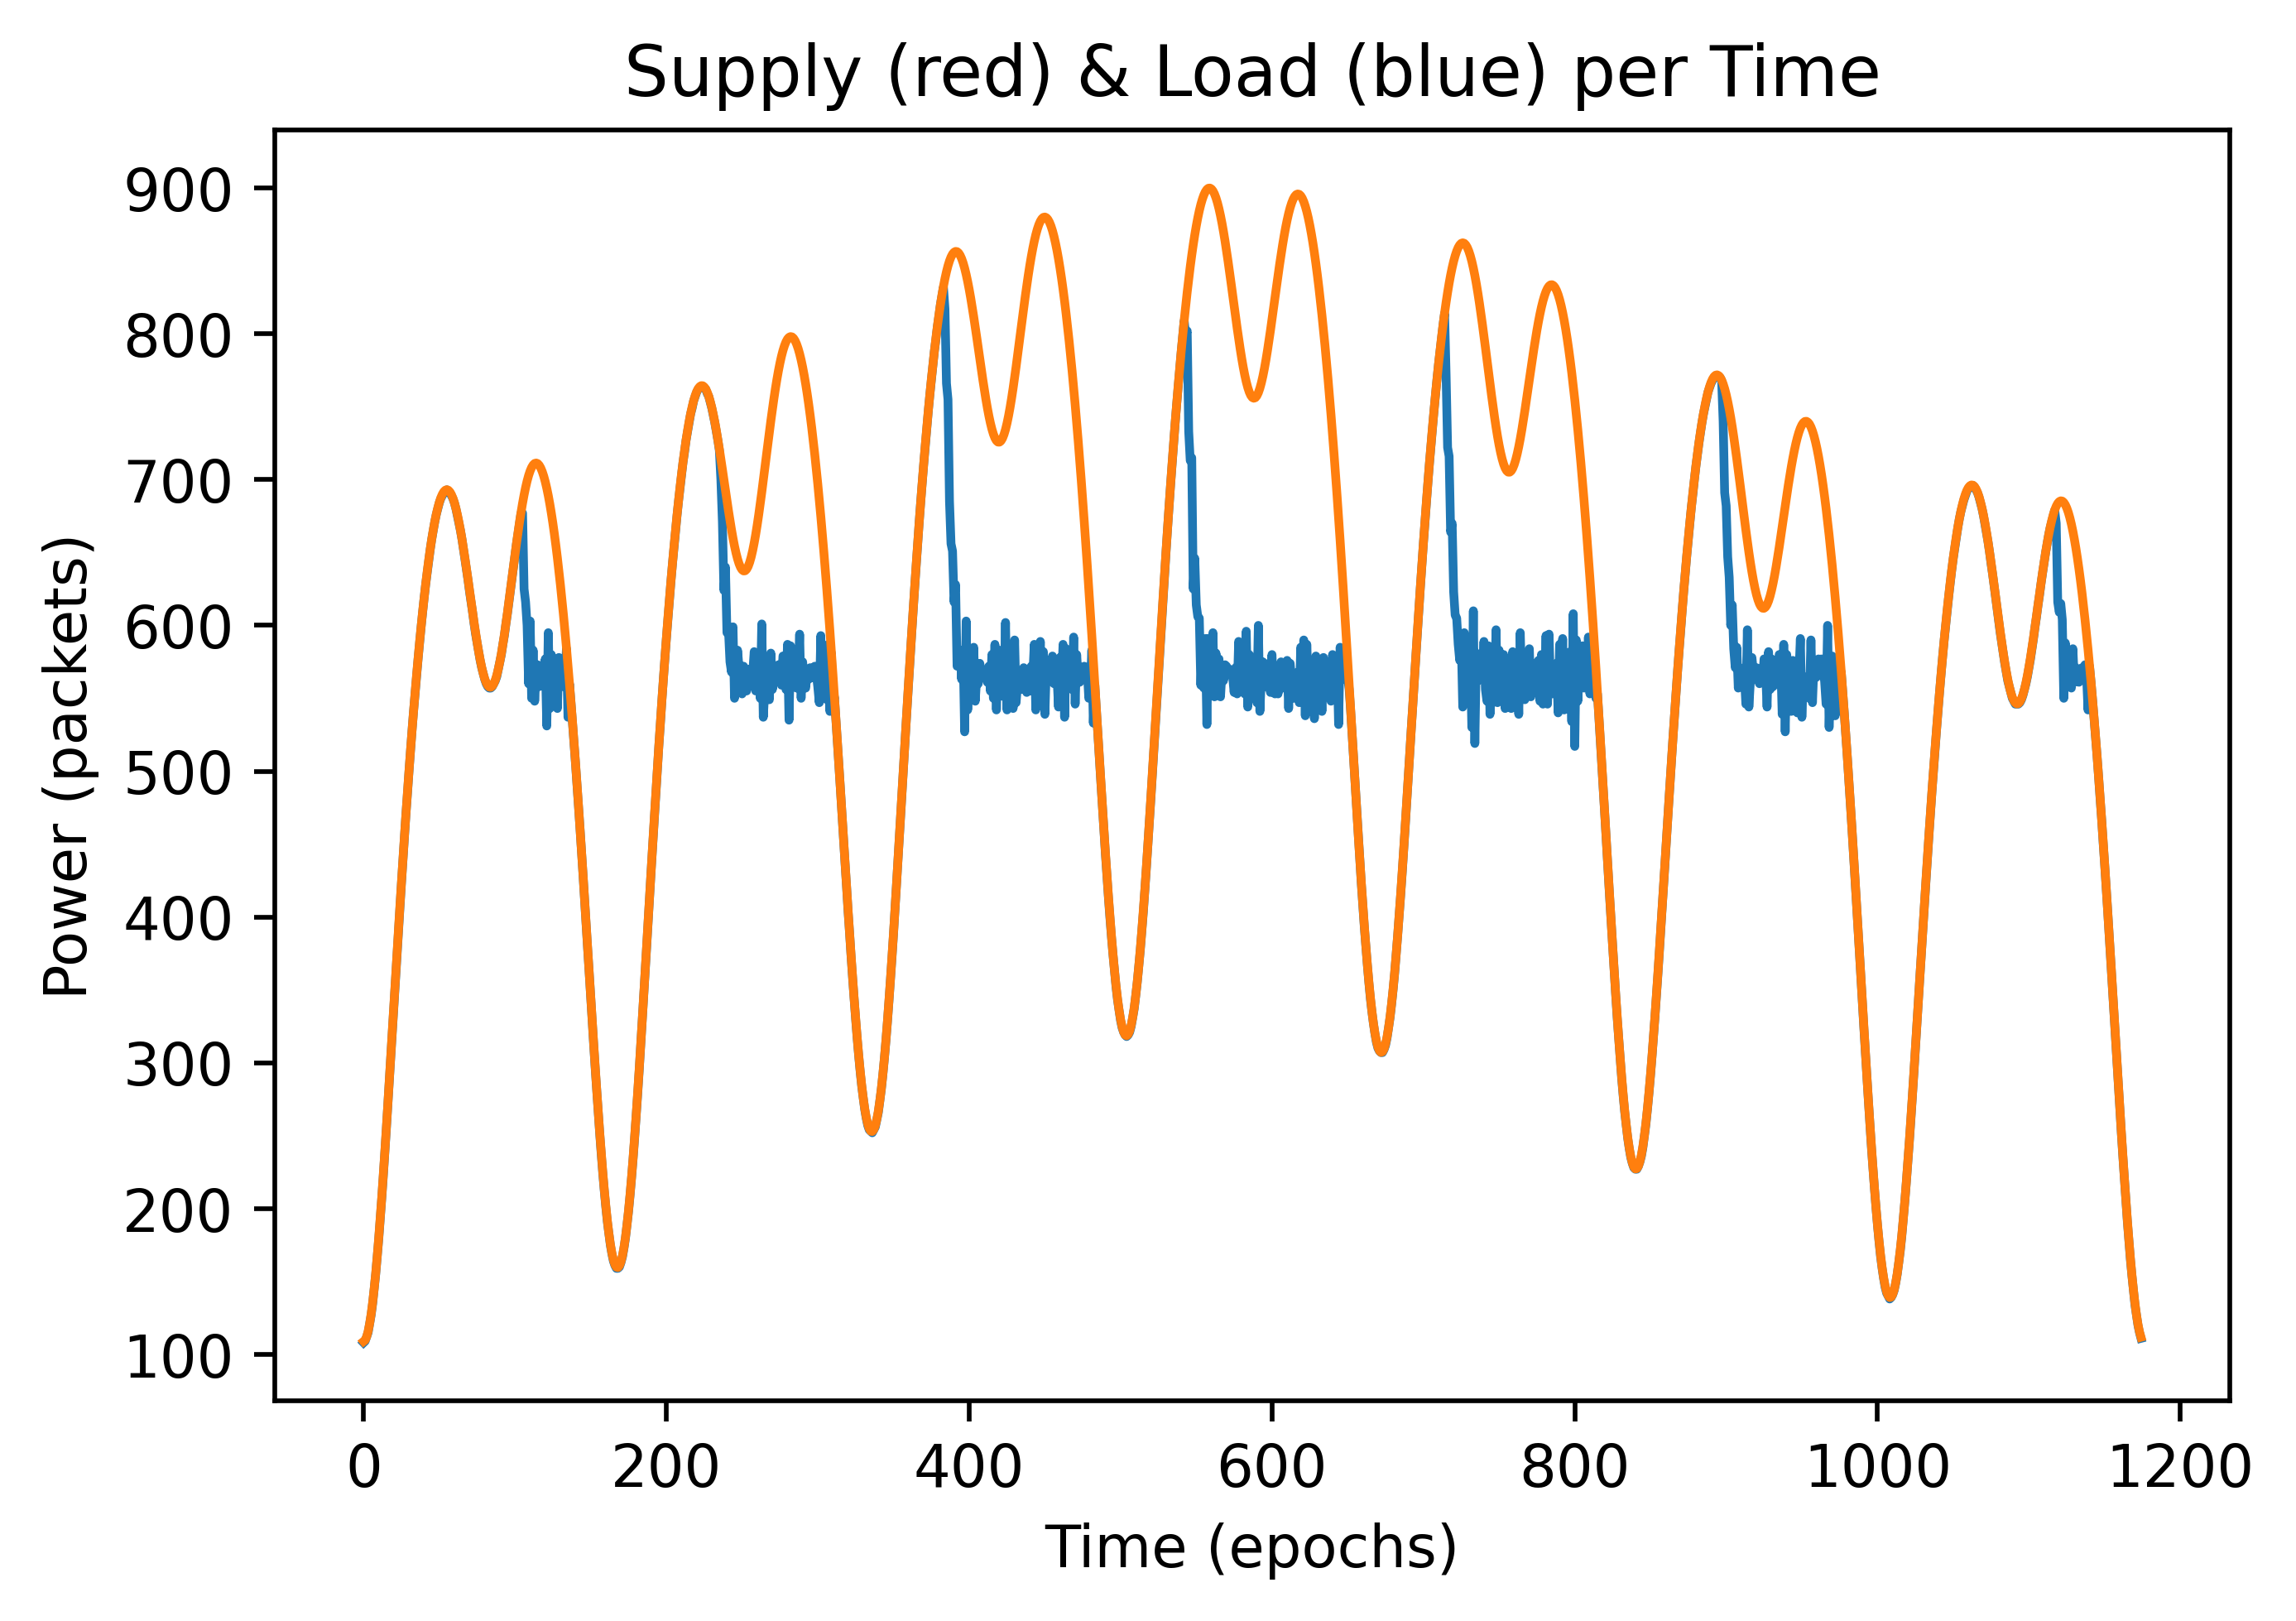

In [8]:
simulated_epochs = len(load)
time = range(simulated_epochs)
supply = [update_supply(i*epoch_length) for i in range(total_epochs)]

rcParams['figure.dpi'] = 508
plt.plot(time, load, supply)
plt.title('Supply (red) & Load (blue) per Time')
plt.xlabel('Time (epochs)')
plt.ylabel('Power (packets)')
plt.show()

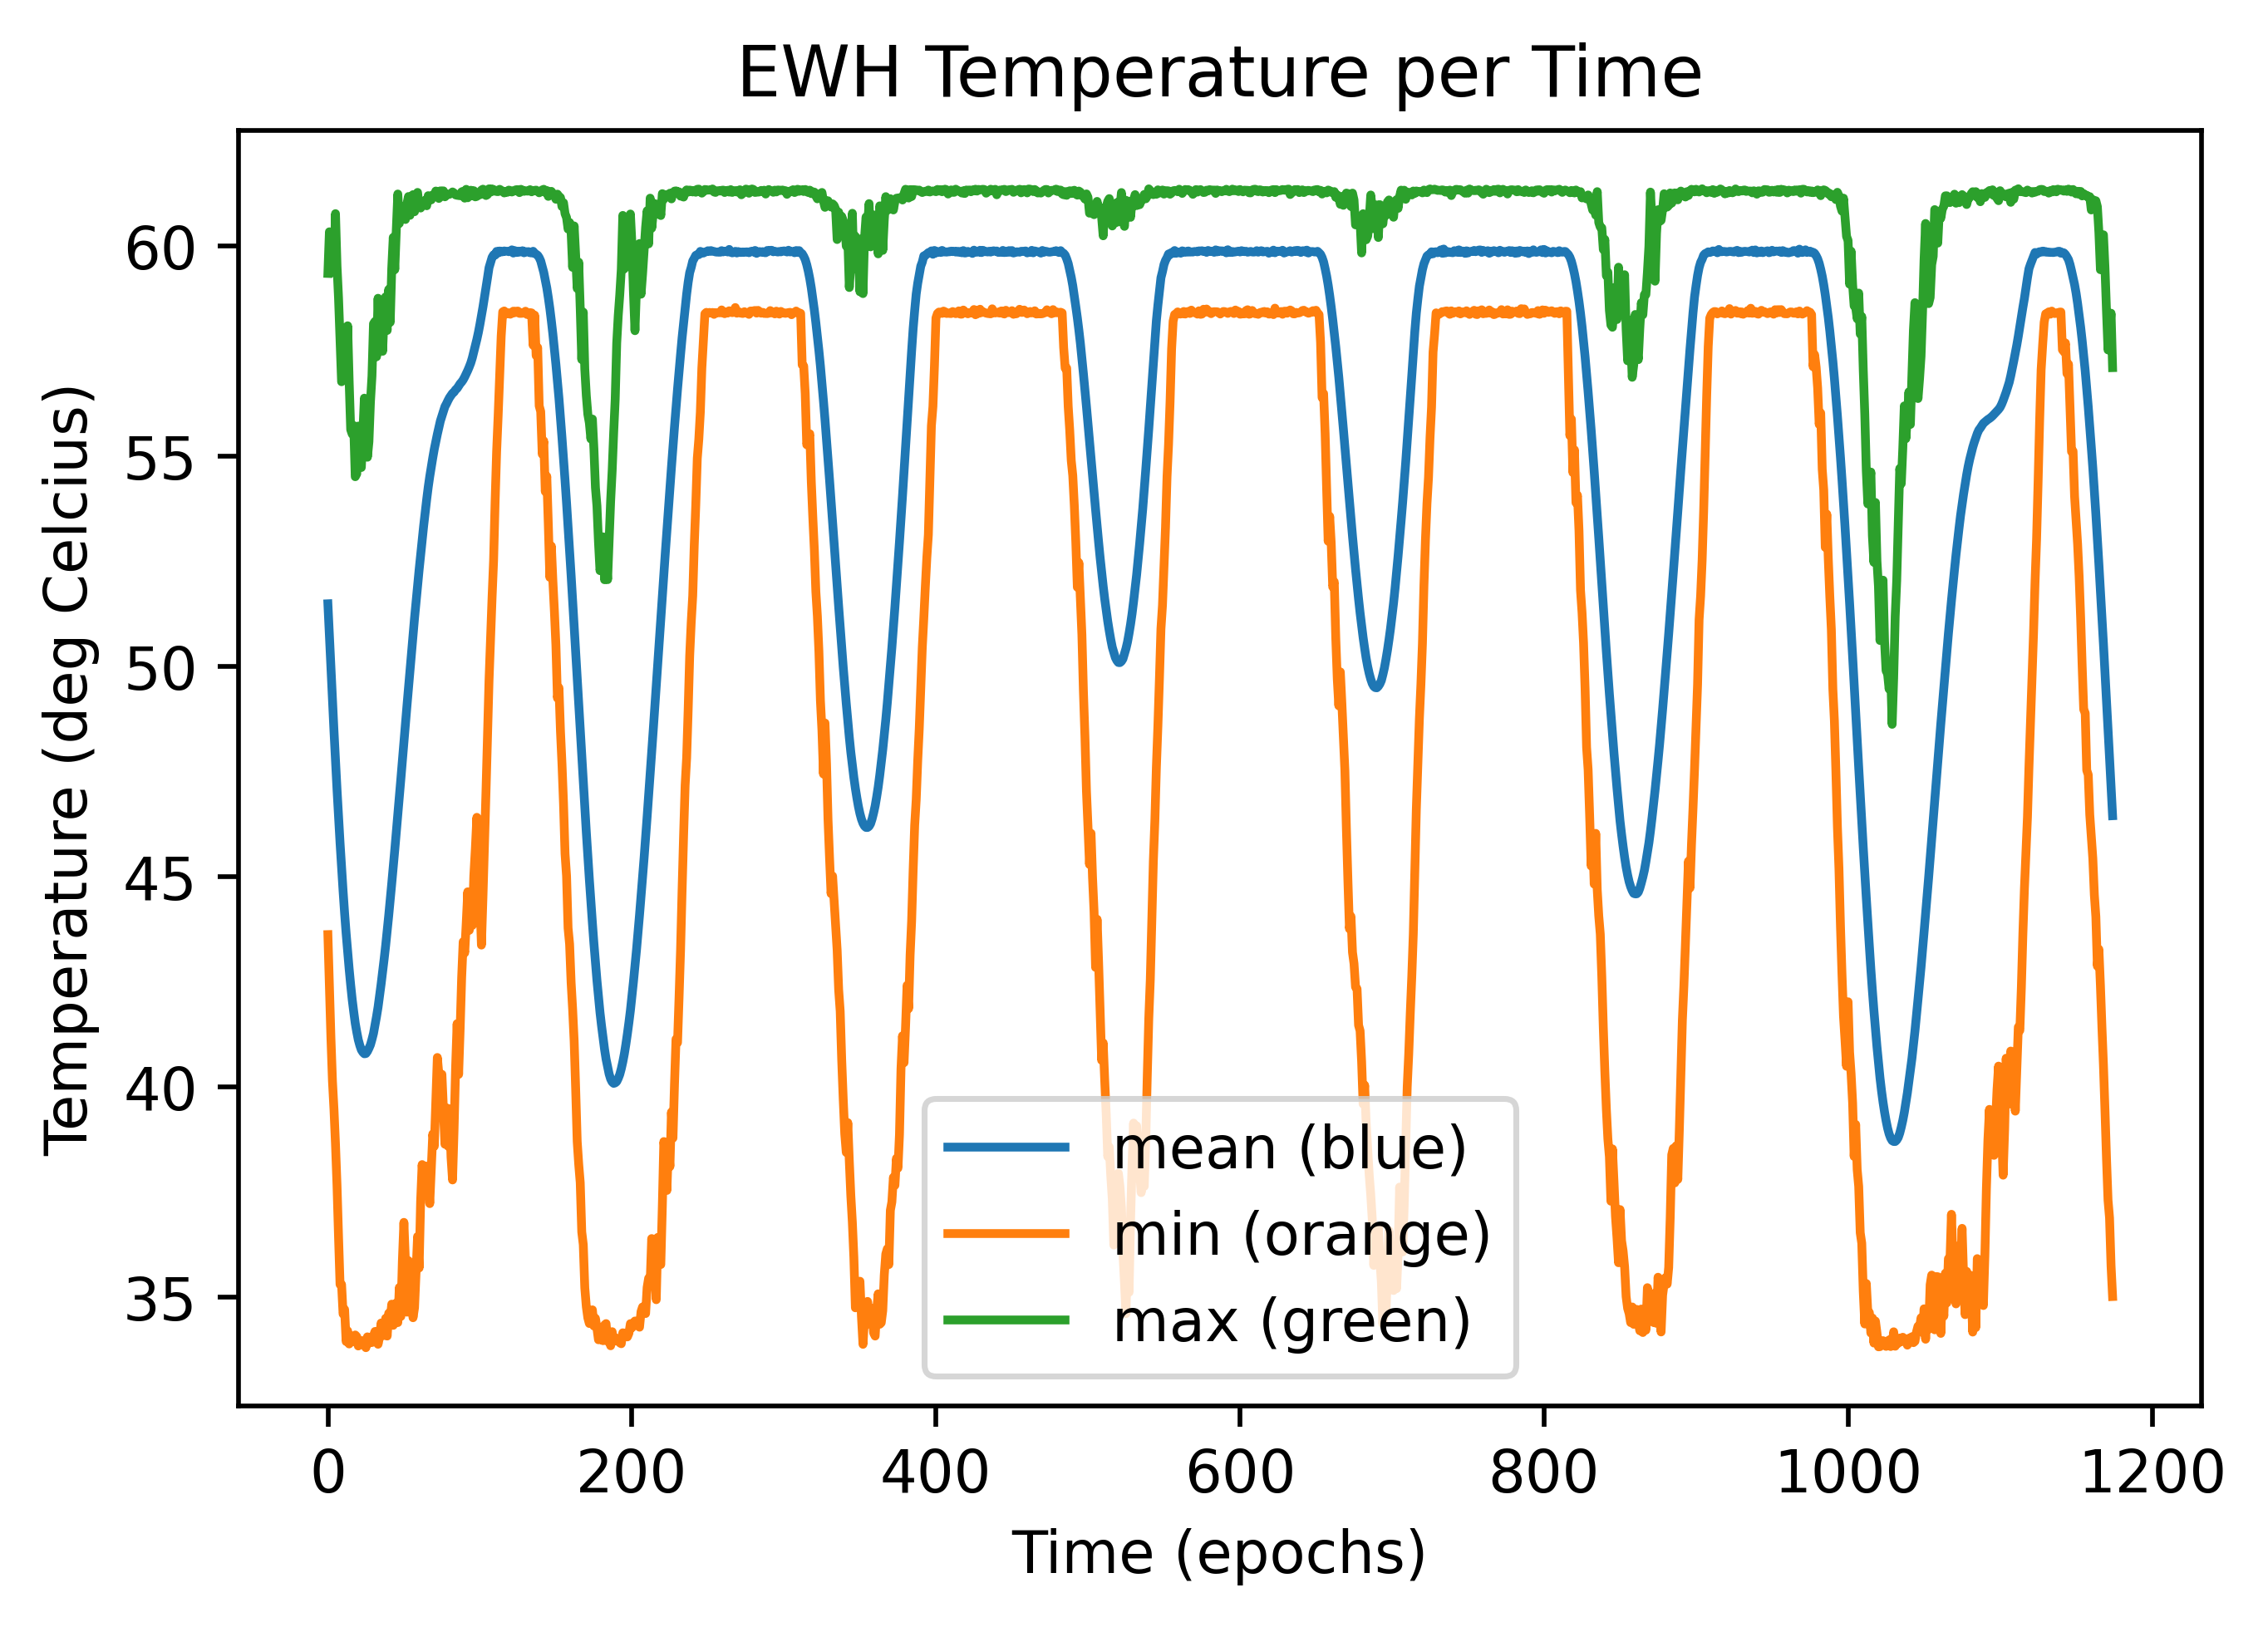

In [9]:
label = ('mean (blue)', 'min (orange)', 'max (green)')
plt.plot(time, state, label=label)
plt.title('EWH Temperature per Time')
plt.xlabel('Time (epochs)')
plt.ylabel('Temperature (deg Celcius)')
plt.legend()
plt.show()

## Discussion & Conclusion

### Undersupply Behaviors

When the grid supply is insufficient to power the sum of requesting appliances, the mean DER state falls to match the power inflow of the supply. When mean DER state falls below mean recovery threshhold, DERs will begin to overload the grid en masse to recover their minimum appropriate state. Because this simulation doesn't have each DER perform full setupoint state recovery mean DER state will tend to the recovery threshhold when experiencing undersupply conditions.

### Oversupply Behaviors

Mean DER state tends to majorly stay around mean setpoint state during oversupply conditions. Notably, when mean state decays during transitory undersupply fluctuations, mean DER state decreases as well. Once the undersupply transitions into oversupply, DERs continue to request packets until reaching their setpoint states. This behavior produces a useage spike which never exceeds available supply but does suddenly drop to mean steady state power draw once mean DER setpoint state is reached. This sudden "recovery spike" is sufficient to cause stress on a real grid and would need to be mitigated by a simple logic addition to the algorithm which could smooth such behavior.

### Appropriate Grid Size

This simulation was not scaled to appropriate grid size or physics according to any meaningful analysis. The sole purpose of this excercise was to verify the conceptual integrity of packetized energy management and explore interesting and otherwise unexpected grid scale statistical behavior.

### Conclusion

This grid management method prevents grid overload by time-delaying energy use. Packetized grid management keeps the grid from being overloaded within normal operating conditions. Several notable behaviors of a simplistic management model introduce new instabilities into the power grid, and future study may work to mitigate these behaviors.

#### A note on code quality

This code was written with addition of arbitrary DERs in mind for future heterogeneity of the population. While it would take some work currently, the architectural modifications required to make this possible are minimal.

## References

Almassalkhi, M., Frolik, J., & Hines, P. (2022, February 15). How to prevent blackouts by packetizing the power grid. IEEE Spectrum. Retrieved April 18, 2022, from https://spectrum.ieee.org/packetized-power-grid

Espinosa, L. A., Almassalkhi, M., Hines, P., & Frolik, J. (2018). Aggregate modeling and coordination of diverse energy resources under Packetized Energy Management. 2017 IEEE 56th Annual Conference on Decision and Control (CDC). https://doi.org/10.1109/cdc.2017.8263849

Espinosa, L. A., Khurram, A., & Almassalkhi, M. (2021). Reference-tracking control policies for packetized coordination of heterogeneous der populations. IEEE Transactions on Control Systems Technology, 29(6), 2427–2443. https://doi.org/10.1109/tcst.2020.3039492

Frolik, J., & Hines, P. (2021, November 9). Systems and Methods for Random-Access Power Management.

Frolik, J., Hines, P., & Almassalkhi, M. (2021, October 19). Packetized Energy Management Control Systems and Methods of Using the Same.

Graber, G., Calderaro, V., Mancarella, P., & Galdi, V. (2019). Two-stage stochastic sizing and packetized energy scheduling of BEV charging stations with quality of service constraints. Applied Energy, 260, 114262. https://doi.org/10.1016/j.apenergy.2019.114262

Nardelli, P. H., Alves, H., Pinomaa, A., Wahid, S., Tome, M. D., Kosonen, A., Kuhnlenz, F., Pouttu, A., & Carrillo, D. (2019). Energy internet via packetized management: Enabling Technologies and deployment challenges. IEEE Access, 7, 16909–16924. https://doi.org/10.1109/access.2019.2896281

Rezaei, P., Frolik, J., & Hines, P. D. (2014). Packetized plug-in Electric Vehicle Charge Management. IEEE Transactions on Smart Grid, 5(2), 642–650. https://doi.org/10.1109/tsg.2013.2291384

Zhang, B., & Baillieul, J. (2013). A packetized direct load control mechanism for demand side management. 2012 IEEE 51st IEEE Conference on Decision and Control (CDC). https://doi.org/10.1109/cdc.2012.6427392 